In [1]:
import numpy as np
import sys
sys.path.append("../src/")
import linear_transformer_lib as lfl
import Data_generator as dg
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def get_data(task_num, input_dim, total_sep_num, alpha=3, tau=5, seed_value=100):
    np.random.seed(seed_value)
    input_all = []
    output_all = []
    x_np, w_np = dg.gauss_root_weight(2*input_dim+1,0,1)
    
    for i in range(task_num):
        input_list = []
        
        input_temp = KL_rf_tensor(x_np, tau=tau, alpha=alpha, dim=total_sep_num, order=20)
        #sin_input = np.array([np.sum(np.sqrt((1-0) / 2) * np.sqrt(2) * np.sin(i * np.pi * x_np) * w_np * input_temp) for i in range(1,input_dim+1)])
        input_temp_result = np.einsum("ab,bc->ca", np.sqrt((1-0) / 2) * np.sqrt(2) *np.sin(np.einsum("ab,bc->ac",((np.arange(input_dim)+1)*np.pi).reshape(-1,1), x_np.reshape(1,-1))),np.einsum("a,ab->ab", w_np, input_temp))
        #input_list.append(sin_input)
        #input_temp = np.array(input_list)
    return input_temp_result

In [4]:
def get_data_normal(task_num, input_dim, total_sep_num, alpha=3, tau=5, seed_value=100):
    np.random.seed(seed_value)
    cv_matrix = np.identity(input_dim)
    mean_arr = np.zeros(input_dim)

    input_all = []
    output_all = []
    for i in range(task_num):
        input_temp = np.random.multivariate_normal(mean_arr, cv_matrix, total_sep_num) # size: total_num, d
    return input_temp

In [5]:
def H1_norm_of_galerkin(coeff_1, coeff_2, start=0, end=1):
    # Here we use sine function as basis
    def function_error(x):
        weight_list_1 = (np.arange(coeff_1.shape[1]) + 1) * np.pi
        sin_list_1 = np.sin(weight_list_1*x)
        
        weight_list_2 = (np.arange(coeff_2.shape[1]) + 1) * np.pi
        sin_list_2 = np.sin(weight_list_2*x)
        return (np.sum(coeff_1 * sin_list_1) - np.sum(coeff_2 * sin_list_2) ) ** 2
        
    def gradient_error(x):
        weight_list_1 = (np.arange(coeff_1.shape[1]) + 1) * np.pi
        cos_list_1 = np.cos(weight_list_1*x)
        
        weight_list_2 = (np.arange(coeff_2.shape[1]) + 1) * np.pi
        cos_list_2 = np.cos(weight_list_2*x)
        return (np.sum(coeff_1 * cos_list_1 * weight_list_1) - np.sum(coeff_2 * cos_list_2 * weight_list_2)) **2
    
    inegral_func, _ = quad(function_error, 0, 1)
    inegral_grad, _ = quad(gradient_error, 0, 1)
    return (inegral_func + inegral_grad) ** (1/2)
    

In [6]:
def get_pos_np(total_dim=1000, selected_num=90):
    pos_list = [0]
    step_size = int(total_dim//(selected_num-1))
    index_temp = step_size
    for i in range(selected_num-2):
        pos_list.append(index_temp)
        index_temp += step_size
    
    pos_list.append(total_dim-1)

    return np.array(pos_list)

def get_LP_basic(input_dim):
    k = [-np.ones(input_dim-1),2*np.ones(input_dim),-np.ones(input_dim-1)]
    offset = [-1,0,1]
    Lap_basic = diags(k,offset).toarray()

    return Lap_basic

In [25]:
d_list = [500,450,400,350,300,250,200,150,125,100,50,40,30,20,10,5]
#n_list = [500]
n_list = [300]
#N_list = [300]
#d_list = [1200,1100,1000,900,800,600,500,400,300,200,100,50,40,30,20,10,5]
#n_list = [800]

tau = 5
alpha = 3 
total_sep_num_train = 1
total_num_train = 2000 #500
max_numerical_dim = 5000
total_sep_num = 2*max_numerical_dim + 1
    
err_t_w_fsmall = []
err_t_w_standard = []
err_fsmall_w_standard = []
err_l2_coeff = []
err_g_w_g_list = []

result_list = []
seed_value_list = [i*100 for i in range(2)]
for rounds in range(len(seed_value_list)):
    
    seed_value = seed_value_list[rounds]
    #input_temp = get_data(1, max_numerical_dim, total_sep_num, alpha=3, tau=5, seed_value=seed_value)
    input_temp = get_data_normal(1, max_numerical_dim, total_sep_num, alpha=3, tau=5, seed_value=seed_value)
    x_np, w_np = dg.gauss_root_weight(2*max_numerical_dim+1,0,1)
    
    np.random.seed(seed_value)
    a_np, v_np = dg.get_a_and_V(x_np, tau=tau, alpha=alpha)
    A_temp = dg.get_A(x_np, w_np, 0 * w_np, max_numerical_dim)
    A_task = A_temp #+ LP_temp * (1000**2)
    A_task_inv = np.linalg.inv(A_task)

    target_output_standard = np.einsum("ab,bc->ac", A_task_inv, input_temp.T)
    target_output_standard_np = np.array([target_output_standard]).transpose((0,2,1))
    
    err_g_w_g_list_temp = []
    err_t_w_standard_temp = []
    err_l2_coeff_temp = []
    for i in range(len(d_list)):
        for j in range(len(n_list)):

            select_num = d_list[i]
            n_temp = n_list[j]

            A_task_temp = A_task[:select_num, :select_num]
            A_task_inv = np.linalg.inv(A_task_temp)

            incontext_len = n_temp
            incontext_len_test = max_numerical_dim
            #best_model_path = "Distribution_shift/Galerkin/Training_data_rf_LN_FD/Model_rf_t5_a3/current_model_best" + "_d" + str(select_num) + "_n" + str(incontext_len) + "_m" + str(total_sep_num_train) + "_N" + str(total_num_train) + "_partial.pkl"
            #best_model_path = "../cluster_training/Training_data_rf_LN_FD/Model_rf_t5_a3/current_model_best" + "_d" + str(select_num) + "_n" + str(incontext_len) + "_m" + str(total_sep_num_train) + "_N" + str(total_num_train) + "_partial.pkl"
            best_model_path = "../cluster_training/Training_data_rf_LN_Galerkin/Model_rf_t5_a3/current_model_best" + "_d" + str(select_num) + "_n" + str(incontext_len) + "_m" + str(total_sep_num_train) + "_N" + str(total_num_train) + "_partial.pkl"
            
            
            input_temp_select = input_temp[-incontext_len_test-1:, :select_num]
            print(input_temp_select.shape)
            target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)

            input_test_np = np.array([input_temp_select]) 
            output_test_np = np.array([target_output]).transpose((0,2,1))

            input_test_np_torch = torch.zeros(size=(incontext_len_test+1, 2*select_num))
            input_test_np_torch[:-1, :select_num] = torch.tensor(input_test_np[-1, :-1,:])
            input_test_np_torch[:-1, select_num:] = torch.tensor(output_test_np[-1, :-1,:])
            input_test_np_torch[-1, :select_num] = torch.tensor(input_test_np[-1, -1,:])

            input_test_np_torch = input_test_np_torch.unsqueeze(0)
            device = "cpu"

            model = lfl.Transformer_linear_partial(incontext_len_test, select_num, device=device)
            model.load_state_dict(torch.load(best_model_path))
            pred_Y = model(input_test_np_torch)

            #err_temp = np.mean(np.sum((pred_Y.detach().numpy() - output_test_np[:,-1,:])**2,axis=1))
            #err_temp_FDM = np.mean(np.sum((target_output_standard_np[:,-1,:select_num] - output_test_np[:,-1,:])**2,axis=1))

            err_g_w_g = H1_norm_of_galerkin(target_output_standard_np[:,-1,:], output_test_np[:,-1,:])
            err_h1 = H1_norm_of_galerkin(pred_Y.detach().numpy(), target_output_standard_np[:,-1,:])

            err_l2_coeff_value = np.sum( (pred_Y.detach().numpy()- target_output_standard_np[:,-1,:select_num]) **2, axis=1)

            err_h1_w_temp = H1_norm_of_galerkin(pred_Y.detach().numpy(), output_test_np[:,-1,:])
            #err_galerkin_w_g = H1_norm_of_galerkin(target_output_standard_np[:,-1,:select_num], output_test_np[:,-1,:])
            print(err_g_w_g)
            print(err_h1)
            err_g_w_g_list_temp.append(err_g_w_g)
            err_t_w_standard_temp.append(err_h1)
            err_l2_coeff_temp.append(err_l2_coeff_value)
            
            result_list.append([err_g_w_g,err_h1,err_l2_coeff_value,seed_value,select_num,n_temp])
            
    err_g_w_g_list.append(err_g_w_g_list_temp)
    err_t_w_standard.append(err_t_w_standard_temp)
    err_l2_coeff.append(err_l2_coeff_temp)
        

(5001, 500)


/tmp/ipykernel_3049163/3379642871.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  inegral_grad, _ = quad(gradient_error, 0, 1)
/tmp/ipykernel_3049163/3379642871.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a 

0.010502780607508968
0.1319431661994532
(5001, 450)
0.01096081967442921
0.13340383550626517
(5001, 400)
0.01126711537234569
0.10457132814824542
(5001, 350)
0.011460461664992944
0.12335525130960735
(5001, 300)
0.01260078118775943
0.09837953665144054
(5001, 250)
0.01354563998160054
0.09320051671089143
(5001, 200)
0.014810034514378375
0.0674204011689726
(5001, 150)
0.018444292844104235
0.05170570262878799
(5001, 125)
0.02094683010745911
0.045841916602573814
(5001, 100)
0.02483504231441695
0.047946805930088855
(5001, 50)
0.03236097291237893
0.06465722233227279
(5001, 40)
0.0347683092881793
0.05675556355897119
(5001, 30)
0.040414561900005204
0.05659437420542342
(5001, 20)
0.05425407969308152
0.057246532138148586
(5001, 10)
0.07076439827286618
0.07185238467673492
(5001, 5)
0.08140753554034824
0.08194086065962365
(5001, 500)
0.009661951995592374
0.28312815497937327
(5001, 450)
0.009574995394510635
0.5698874919202616
(5001, 400)
0.010910311719890249
0.18450695687750263
(5001, 350)
0.0116442129

In [26]:
for i in range(len(result_list)):
    result_list[i][2] = result_list[i][2][0]

In [27]:
result_pd = pd.DataFrame(data=result_list, columns=["h1_g","h1_err","l2_coeff","seed","d","n"])

In [28]:
result_pd

,h1_g,h1_err,l2_coeff,seed,d,n
0,0.010503,0.131943,0.001843,0,500,300
1,0.010961,0.133404,0.000945,0,450,300
2,0.011267,0.104571,0.001173,0,400,300
3,0.011460,0.123355,0.000593,0,350,300
4,0.012601,0.098380,0.000938,0,300,300
5,0.013546,0.093201,0.000160,0,250,300
6,0.014810,0.067420,0.000272,0,200,300
7,0.018444,0.051706,0.000018,0,150,300
8,0.020947,0.045842,0.000064,0,125,300
9,0.024835,0.047947,0.000027,0,100,300


In [29]:
c1 = result_pd["d"] != 1100
c2 = result_pd["d"] != 1200
c3 = result_pd["d"] != 1300
c4 = result_pd["d"] != 1400
c5 = result_pd["d"] != 1500
c = c1 & c2 & c3 & c4 & c5
result_pd_selected = result_pd[c]

In [30]:
result_pd_selected

,h1_g,h1_err,l2_coeff,seed,d,n
0,0.010503,0.131943,0.001843,0,500,300
1,0.010961,0.133404,0.000945,0,450,300
2,0.011267,0.104571,0.001173,0,400,300
3,0.011460,0.123355,0.000593,0,350,300
4,0.012601,0.098380,0.000938,0,300,300
5,0.013546,0.093201,0.000160,0,250,300
6,0.014810,0.067420,0.000272,0,200,300
7,0.018444,0.051706,0.000018,0,150,300
8,0.020947,0.045842,0.000064,0,125,300
9,0.024835,0.047947,0.000027,0,100,300


/tmp/ipykernel_3049163/2476095431.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=result_pd_selected, x="d",y="h1_err",err_style="bars",markers=True, linewidth=2, palette="coolwarm") #sns.color_palette("husl"))


Text(0.5, 1.0, 'n=300, N=300 (l2-err)')

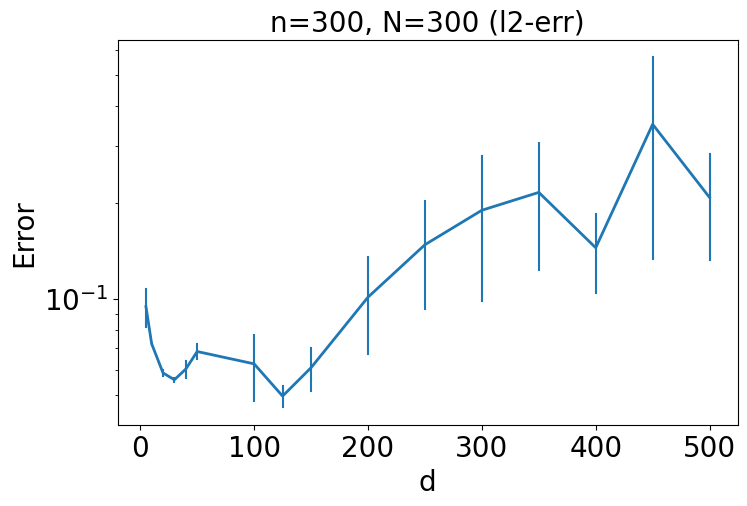

In [31]:
f, ax = plt.subplots(figsize=(8,5))
#sns.lineplot(data=data_pd[data_pd["n"]==20], x="index",y="err_ln",err_style="bars",markers=True, label="n=" + str(20),  linewidth=2)
#sns.lineplot(data=data_shift_new[data_shift_new["index"]==0], x="m",y="err_log10",err_style="bars",markers=True, linewidth=2) #sns.color_palette("husl"))
sns.lineplot(data=result_pd_selected, x="d",y="h1_err",err_style="bars",markers=True, linewidth=2, palette="coolwarm") #sns.color_palette("husl"))

#legend = plt.legend(fontsize=12, loc =1)
# i = 0
# for text in legend.texts:    
#     text.set_text(r"$(\alpha,\tau)=(" + str(alpha_tau_v_pairs[i][0]) + ", " + str(str(alpha_tau_v_pairs[i][1])) + ")$")
#     i += 1
#plt.xticks([i for i in range(len(left_right_pair))], label_list, fontsize=20)

ax.set(yscale="log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("d", fontsize=20)
#plt.xlabel("")
plt.ylabel("Error", fontsize=20)
#plt.ylabel("")
plt.title("n=300, N=300 (l2-err)", fontsize=20)

In [13]:
select_num = 10
LP_temp = get_LP_basic(select_num)
pos_np_10 = get_pos_np(total_dim=1000, selected_num=select_num)
diagonal_entries = V_list[pos_v][pos_np_10]
A_temp = np.diag(diagonal_entries)
A_task = A_temp + LP_temp * (select_num**2)
A_task_inv = np.linalg.inv(A_task)

input_temp_select = input_temp[-2:, pos_np_10]
print(input_temp_select.shape)
target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)
output_test_np_10 = np.array([target_output]).transpose((0,2,1))

NameError: name 'V_list' is not defined

In [165]:
pred_Y = model(input_temp_select)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [ ]:
select_num = 100
LP_temp = get_LP_basic(select_num)
pos_np_100 = get_pos_np(total_dim=1000, selected_num=select_num)
diagonal_entries = V_list[pos_v][pos_np_100]
A_temp = np.diag(diagonal_entries)
A_task = A_temp + LP_temp * (select_num**2)
A_task_inv = np.linalg.inv(A_task)

input_temp_select = input_temp[-2:, pos_np_100]
print(input_temp_select.shape)
target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)
output_test_np_100 = np.array([target_output]).transpose((0,2,1))

In [ ]:
select_num = 500
LP_temp = get_LP_basic(select_num)
pos_np_500 = get_pos_np(total_dim=1000, selected_num=select_num)
diagonal_entries = V_list[pos_v][pos_np_500]
A_temp = np.diag(diagonal_entries)
A_task = A_temp + LP_temp * (select_num**2)
A_task_inv = np.linalg.inv(A_task)

input_temp_select = input_temp[-2:, pos_np_500]
print(input_temp_select.shape)
target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)
output_test_np_500 = np.array([target_output]).transpose((0,2,1))

In [ ]:
select_num = 1000
LP_temp = get_LP_basic(select_num)
pos_np_1000 = get_pos_np(total_dim=1000, selected_num=select_num)
diagonal_entries = V_list[pos_v][pos_np_1000]
A_temp = np.diag(diagonal_entries)
A_task = A_temp + LP_temp * (select_num**2)
A_task_inv = np.linalg.inv(A_task)

input_temp_select = input_temp[-2:, pos_np_1000]
print(input_temp_select.shape)
target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)
output_test_np_1000 = np.array([target_output]).transpose((0,2,1))

In [ ]:
output_test_np_old = output_test_np

In [14]:
plt.figure(figsize=(20,10))
plt.plot(pos_np_10/1000, abs(output_test_np_10[-1,-1,:]), label="FDM gridsize=10")
plt.plot(pos_np_100/1000, abs(output_test_np_100[-1,-1,:]), label="FDM gridsize=100")
plt.plot(pos_np_500/1000, abs( output_test_np_500[-1,-1,:]), label="FDM gridsize=500")
plt.plot(pos_np_1000/1000, abs( output_test_np_1000[-1,-1,:]), label="FDM gridsize=1000")
#plt.plot(pos_np_500/1000, abs( target_output_standard_np[-1,-1,pos_np]), label="FDM gridsize=1000")
plt.legend()

NameError: name 'output_test_np_10' is not defined

<Figure size 2000x1000 with 0 Axes>

In [1]:
err_t_w_standard_np = np.array(err_t_w_standard)
err_t_w_standard_np_mean = np.mean(err_t_w_standard_np,axis=0)

NameError: name 'np' is not defined

In [ ]:
plt.figure(figsize=(8,5))
#plt.plot(d_list, np.log10(err_t_w_fsmall), ".-", linewidth=2, alpha=0.6, label="|TF (d) - Galerkin (gridsize=d)|")
plt.plot(d_list, np.log10(err_t_w_standard_np_mean), "-", linewidth=2, alpha=1, label="H1(TF (d), Galerkin (order=1500))")
#plt.plot(d_list, np.log10(err_fsmall_w_standard), ".-", linewidth=2, alpha=0.6,  label="|Galerkin (order=d) - Galerkin (order=1000)|")
plt.xlabel("d", fontsize=15)
plt.ylabel(r"Log$_{10}$(Err)", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("n=300, N=300", fontsize=15)
plt.grid(True)
plt.legend(loc = 4)

In [13]:
err_g_w_g_list_np = np.array(err_g_w_g_list)
err_g_w_g_list_np_mean = np.mean(err_g_w_g_list_np,axis=0)


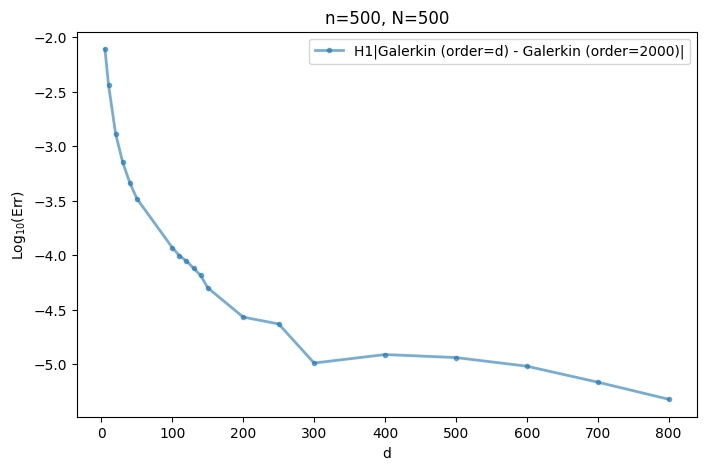

In [14]:
plt.figure(figsize=(8,5))
plt.plot(d_list, np.log10(err_g_w_g_list_np_mean), ".-", linewidth=2, alpha=0.6, label="H1|Galerkin (order=d) - Galerkin (order=2000)|")
plt.xlabel("d")
plt.ylabel(r"Log$_{10}$(Err)")
plt.title("n=500, N=500")
plt.legend()

In [27]:
err_temp_FDM

NameError: name 'err_temp_FDM' is not defined

Analyze PDE

In [6]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [87]:
d_list = [5, 10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
n_list = [500]
tau = 5
alpha = 3 
total_sep_num_train = 1
total_num_train = 500
max_numerical_dim = 1000
total_sep_num = 2*max_numerical_dim + 1
    
err_t_w_fsmall = []
err_t_w_standard = []
err_fsmall_w_standard = []
err_l2_coeff = []
err_g_w_g_list = []
seed_value_list = [i*100 for i in range(1)]
result_list = []
result_list_coeff = []
for rounds in range(len(seed_value_list)):
    
    seed_value = seed_value_list[rounds]
    input_temp = get_data(1, max_numerical_dim, total_sep_num, alpha=3, tau=5, seed_value=seed_value)
    #input_temp[-1, :] = np.zeros(max_numerical_dim)
    #input_temp[-1, :300] = 1 / 300
            
    x_np, w_np = dg.gauss_root_weight(2*max_numerical_dim+1,0,1)
    
    np.random.seed(seed_value)
    a_np, v_np = dg.get_a_and_V(x_np, tau=tau, alpha=alpha)
    A_temp = dg.get_A(x_np, 1*w_np, v_np*w_np, max_numerical_dim)
    
    #A_task = A_temp #+ LP_temp * (1000**2)
    A_task_inv = np.linalg.inv(A_temp)

    target_output_standard = np.einsum("ab,bc->ac", A_task_inv, input_temp.T)
    target_output_standard_np = np.array([target_output_standard]).transpose((0,2,1))
    
    err_g_w_g_list_temp = []
    err_t_w_standard_temp = []
    err_l2_coeff_temp = []
    for i in range(len(d_list)):
        for j in range(len(n_list)):

            select_num = d_list[i]
            n_temp = n_list[j]

            A_task_temp = A_temp[:select_num, :select_num]
            A_task_inv = np.linalg.inv(A_task_temp)

            incontext_len = n_temp
            incontext_len_test = max_numerical_dim
            #best_model_path = "Distribution_shift/Galerkin/Training_data_rf_LN_FD/Model_rf_t5_a3/current_model_best" + "_d" + str(select_num) + "_n" + str(incontext_len) + "_m" + str(total_sep_num_train) + "_N" + str(total_num_train) + "_partial.pkl"
            best_model_path = "../cluster_training/Training_data_rf_LN_FD/Model_rf_t5_a3/current_model_best" + "_d" + str(select_num) + "_n" + str(incontext_len) + "_m" + str(total_sep_num_train) + "_N" + str(total_num_train) + "_partial.pkl"

            input_temp_select = input_temp[-incontext_len_test-1:, :select_num]
            
            print(input_temp_select.shape)
            target_output = np.einsum("ab,bc->ac", A_task_inv, input_temp_select.T)

            input_test_np = np.array([input_temp_select]) 
            output_test_np = np.array([target_output]).transpose((0,2,1))

            input_test_np_torch = torch.zeros(size=(incontext_len_test+1, 2*select_num))
            input_test_np_torch[:-1, :select_num] = torch.tensor(input_test_np[-1, :-1,:])
            input_test_np_torch[:-1, select_num:] = torch.tensor(output_test_np[-1, :-1,:])
            input_test_np_torch[-1, :select_num] = torch.tensor(input_test_np[-1, -1,:]) # define input function value

            input_test_np_torch = input_test_np_torch.unsqueeze(0)
            device = "cpu"

            model = lfl.Transformer_linear_partial(incontext_len_test, select_num, device=device)
            model.load_state_dict(torch.load(best_model_path))
            pred_Y = model(input_test_np_torch)
            
            result_list.append(pred_Y.detach().numpy())
            result_list_coeff.append(output_test_np[:,-1,:])
            #err_temp = np.mean(np.sum((pred_Y.detach().numpy() - output_test_np[:,-1,:])**2,axis=1))
            #err_temp_FDM = np.mean(np.sum((target_output_standard_np[:,-1,:select_num] - output_test_np[:,-1,:])**2,axis=1))

            err_g_w_g = H1_norm_of_galerkin(target_output_standard_np[:,-1,:], output_test_np[:,-1,:])
            err_h1 = H1_norm_of_galerkin(pred_Y.detach().numpy(), target_output_standard_np[:,-1,:])

            err_l2_coeff_value = np.sum( (pred_Y.detach().numpy()- target_output_standard_np[:,-1,:select_num]) **2, axis=1)

            err_h1_w_temp = H1_norm_of_galerkin(pred_Y.detach().numpy(), output_test_np[:,-1,:])
            #err_galerkin_w_g = H1_norm_of_galerkin(target_output_standard_np[:,-1,:select_num], output_test_np[:,-1,:])
            print(err_g_w_g)
            print(err_h1)
            err_g_w_g_list_temp.append(err_g_w_g)
            err_t_w_standard_temp.append(err_h1)
            err_l2_coeff_temp.append(err_l2_coeff_value)
            
    err_g_w_g_list.append(err_g_w_g_list_temp)
    err_t_w_standard.append(err_t_w_standard_temp)
    err_l2_coeff.append(err_l2_coeff_temp)
        

(1001, 5)
0.007737830051133374
0.007739238624351863
(1001, 10)


/tmp/ipykernel_1065597/3379642871.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  inegral_grad, _ = quad(gradient_error, 0, 1)


0.003670924523640346
0.0036720678978949335
(1001, 20)
0.0013024385307442159
0.0013043212726131191
(1001, 30)
0.0007135031594259247
0.0007268739591292717
(1001, 40)
0.0004637961282057898
0.0005476490834136414
(1001, 50)
0.0003315879812959754
0.0003532820740984619
(1001, 100)
0.00011903593166752926
0.000309219965223741
(1001, 150)
5.249362020776579e-05
0.0001495761731511303
(1001, 200)


/tmp/ipykernel_1065597/3379642871.py:20: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  inegral_grad, _ = quad(gradient_error, 0, 1)


3.0485993594638877e-05
0.0002922609061013899
(1001, 300)
1.4549704762042239e-05
0.0003638039571516176
(1001, 400)
1.4106279447201502e-05
0.0012467284834949016
(1001, 500)
1.263405367221315e-05
0.002524082272800756
(1001, 600)
1.0504318382393998e-05
0.00017065581125084889
(1001, 700)
7.705116971809534e-06
0.00040601960203840494
(1001, 800)
5.319228518855493e-06
0.0006632749870959807


In [88]:
def get_func(x_np, coeff):
    result_list = []
    for i in range(x_np.shape[0]):
        x_temp = x_np[i]
        weight_list = (np.arange(coeff.shape[1]) + 1) * np.pi
        sin_list = np.sin(weight_list*x_temp)
        result_temp = np.sum(coeff * sin_list) 
        result_list.append(result_temp)
    return np.array(result_list)

In [89]:
def target_analytical_solution(x_np):
    return np.sin(np.pi * x_np) / (2 * np.pi **2) + np.sin(2 * np.pi * x_np) / (8 * np.pi ** 2)

In [90]:
func_value_list = []
for i in range(len(result_list)):
    coeff = result_list[i] 
    func_temp_valu = get_func(x, coeff.reshape(1,-1))
    func_value_list.append(func_temp_valu)

In [91]:
target_value_list = []
for i in range(len(result_list_coeff)):
    coeff = result_list_coeff[i] 
    func_temp_valu = get_func(x, coeff.reshape(1,-1))
    target_value_list.append(func_temp_valu)

In [92]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Domain and grid parameters
L = 1.0        # Length of the domain
N = 500        # Number of grid points
dx = L / (N-1) # Grid spacing

# Create the grid points
x = np.linspace(0, L, N)

# Define the source term f(x) and the zero-order term q(x)
f = 0# (1/max_numerical_dim) * (np.sin(np.pi * x) + np.sin(2* np.pi * x))  # Example source term f(x) = sin(pi * x)
for i in range(2):
    f += 1/2 * (np.sin(np.pi * (i+1)* x))
q = np.ones(N) * 0   # Example zero-order term q(x) = 1 (constant)

# Build the finite difference matrix A
diagonals = []
main_diag = 2.0 / dx**2 * np.ones(N) + q  # Main diagonal (-2 / dx^2 + q(x))
off_diag = -np.ones(N-1) / dx**2            # Off diagonals (1 / dx^2)
diagonals.append(main_diag)
diagonals.append(off_diag)
diagonals.append(off_diag)

# Build the sparse matrix A
A = sp.diags(diagonals, [0, 1, -1], format='csr')

# Apply Dirichlet boundary conditions (u(0) = u(1) = 0)
A = A[1:-1, 1:-1]  # Remove first and last rows/columns

# Modify the source term to account for boundary conditions
f = f[1:-1]  # Remove boundary points

# Solve the linear system A * u = f
u_interior = spla.spsolve(A, f)

# Add the boundary conditions back into the solution
u = np.zeros(N)
u[1:-1] = u_interior

In [93]:
target_output_standard_np.shape

(1, 2001, 1000)

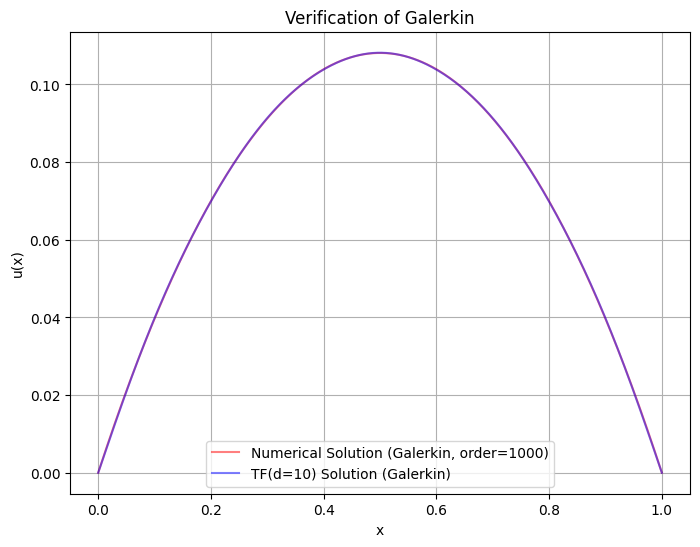

In [100]:
# Plot the solution
plt.figure(figsize=(8, 6))
#plt.plot(x, u, label='Numerical Solution (FDM)', color='b')
plt.plot(x, get_func(x, target_output_standard_np[-1,-1,:].reshape(1,-1)), label='Numerical Solution (Galerkin, order=1000)', alpha=0.5, color='r')
#plt.plot(x, target_value_list[3], label='Numerical Solution (Galerkin, order=1000)', color='r')
plt.plot(x, func_value_list[1], label='TF(d=10) Solution (Galerkin)', alpha=0.5, color='b')
#plt.plot(x, target_analytical_solution(x), label='Analytical Solution', color='r')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Verification of Galerkin')
plt.grid(True)
plt.legend()
plt.show()


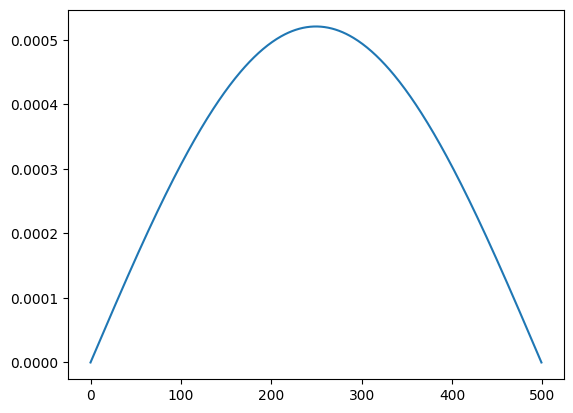

In [58]:
plt.plot(get_func(x, target_output_standard_np[-1,-1,:].reshape(-1,1)))

In [78]:
input_test = get_data(1, max_numerical_dim, 4, alpha=3, tau=5, seed_value=seed_value)
input_test[-1, :] = np.zeros(max_numerical_dim)
input_test[-1, :2] = 1 / 2
    

In [61]:
x_np, w_np = dg.gauss_root_weight(2*1000+1,0,1)

In [79]:
A_temp = dg.get_A(x_np, 1 * w_np, 0 * w_np, 1000)

In [80]:
A_temp_inv = np.linalg.inv(A_temp)

In [81]:
input_test.shape

(4, 1000)

In [82]:
#y_ = np.einsum("ab,b->a", A_temp_inv, input_test.T)

target_output_standard = np.einsum("ab,bc->ac", A_temp_inv, input_test.T)
target_output_standard_np = np.array([target_output_standard]).transpose((0,2,1))

In [83]:
target_output_standard_np.shape

(1, 4, 1000)

In [84]:
def get_func(x_np, coeff):
    result_list = []
    for i in range(x_np.shape[0]):
        x_temp = x_np[i]
        weight_list = (np.arange(coeff.shape[1]) + 1) * np.pi
        sin_list = np.sin(weight_list*x_temp)
        result_temp = np.sum(coeff * sin_list) 
        result_list.append(result_temp)
    return np.array(result_list)

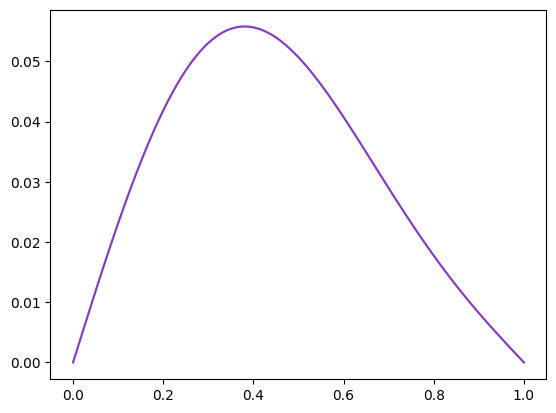

In [85]:
plt.plot(x, get_func(x, target_output_standard_np[-1,-1,:].reshape(1,-1)), alpha=0.5, color="r")
plt.plot(x, u, label='Numerical Solution (FDM)',  alpha=0.5, color='b')

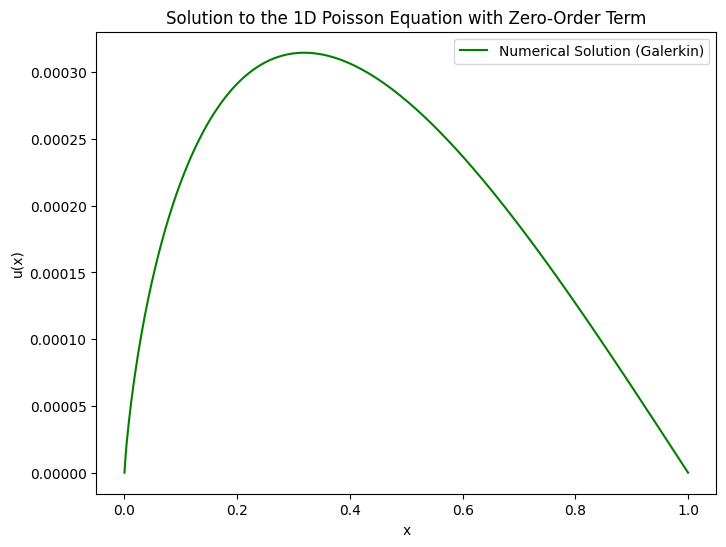

In [27]:
# Plot the solution
plt.figure(figsize=(8, 6))
#plt.plot(x, u, label='Numerical Solution (FDM)', color='b')
plt.plot(x, get_func(x, target_output_standard_np[-1,-1,:].reshape(1,-1)), label='Numerical Solution (Galerkin)', color='g')
#plt.plot(x, func_value_list[-1], label='Numerical Solution (Galerkin)', color='r')
#plt.plot(x, target_analytical_solution(x), label='Analytical Solution', color='g')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Solution to the 1D Poisson Equation with Zero-Order Term')
plt.legend()
plt.show()
